<a href="https://colab.research.google.com/github/mahesh-keswani/pytorch-example-notebook/blob/main/12_Pytorch_SimpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import  torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

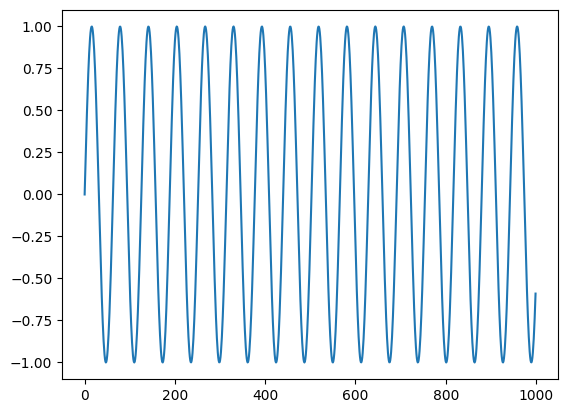

In [2]:
N = 1000
series = np.sin(0.1*np.arange(N)) # + np.random.randn(N) * 0.1
plt.plot(series)

In [3]:
# building dataset
X = []
Y = []
T =  10
for i in range(len(series) - T):
    x = series[i:i+T]
    X.append(x)
    y = series[i+T]
    Y.append(y)

#  RNN expects  3d  output
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(X.shape, Y.shape)

(990, 10, 1) (990, 1)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super(SimpleRNN, self).__init__()
        self.input_dimension = input_size
        self.hidden_dimension = hidden_size
        self.out_dimension = output_size
        self.number_of_layers = n_layers

        # batch_first = True  means we batch on the first dimension of the data (N x T)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True, nonlinearity = 'tanh')
        self.fc = nn.Linear(self.hidden_dimension, self.out_dimension)

    def forward(self, X):
        # initial state
        # input is NxTxD, h0 is LxNxM
        h0 = torch.zeros(self.number_of_layers, X.size(0), self.hidden_dimension).to(device)

        # output is of size (N, T, hidden_dimension)
        # second return value is hidden states at each hidden layer, we  dont need those now
        out, _ = self.rnn(X, h0)

        # we only want the hidden state at the final step thats why out[:, -1,  :]
        out = self.fc(out[:, -1, :])
        return out

In [6]:
model = SimpleRNN(input_size=1, hidden_size=5, output_size=1, n_layers=1).to(device)

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
X_train = torch.from_numpy(X[:N//2].astype(np.float32)).to(device)
Y_train = torch.from_numpy(Y[:N//2].astype(np.float32)).to(device)
X_test = torch.from_numpy(X[N//2:].astype(np.float32)).to(device)
Y_test = torch.from_numpy(Y[N//2:].astype(np.float32)).to(device)

In [9]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([495, 10, 1]),
 torch.Size([495, 1]),
 torch.Size([495, 10, 1]),
 torch.Size([495, 1]))

In [10]:
EPOCHS = 100
train_losses = np.zeros(EPOCHS)
test_losses = np.zeros(EPOCHS)

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    train_losses[epoch] = loss.item()

    loss.backward()
    optimizer.step()

    # gather  test loss as well
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, Y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch 10/100, Train Loss: 0.2148, Test Loss: 0.2000
Epoch 20/100, Train Loss: 0.0240, Test Loss: 0.0167
Epoch 30/100, Train Loss: 0.0265, Test Loss: 0.0204
Epoch 40/100, Train Loss: 0.0131, Test Loss: 0.0133
Epoch 50/100, Train Loss: 0.0075, Test Loss: 0.0072
Epoch 60/100, Train Loss: 0.0068, Test Loss: 0.0064
Epoch 70/100, Train Loss: 0.0055, Test Loss: 0.0054
Epoch 80/100, Train Loss: 0.0047, Test Loss: 0.0045
Epoch 90/100, Train Loss: 0.0040, Test Loss: 0.0039
Epoch 100/100, Train Loss: 0.0034, Test Loss: 0.0033


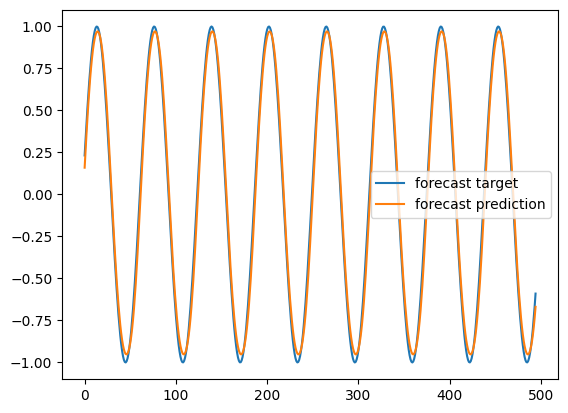

In [11]:
# WRONG way to forecast
validation_targets = Y[N//2:]
validation_preds = []
i = 0

while len(validation_preds) < len(validation_targets):
    input = X_test[i].reshape(1, T, 1)
    output = model(input)[0, 0].item()
    validation_preds.append(output)
    i += 1

plt.plot(validation_targets, label='forecast target')
plt.plot(validation_preds, label='forecast prediction')
plt.legend()

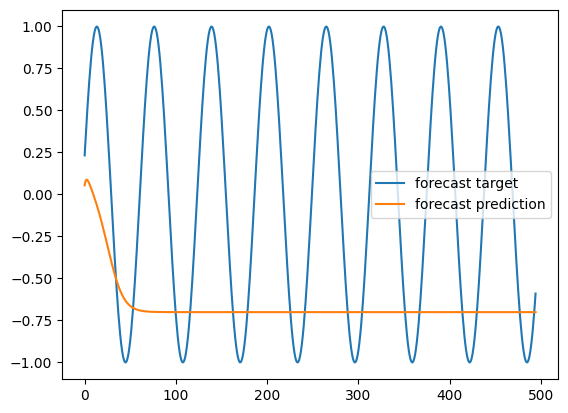

In [12]:
# correct way to make forecast
validation_targets = Y[N//2:]
validation_preds = []
i = 0
last_x = X_train[-1].view(T)

while len(validation_preds) < len(validation_targets):
    input = last_x.reshape(1, T, 1)
    output = model(input)
    validation_preds.append(output[0, 0].item())

    last_x = torch.cat((last_x[1:], output[0]))

plt.plot(validation_targets, label='forecast target')
plt.plot(validation_preds, label='forecast prediction')
plt.legend()

In [13]:
# We  can see RNN does not perform well because it has more parameters to adjust (i.e  it provides more flexibility for complex  jobs)

In [15]:
# we can see the output of model is single scaler as  have only one item in single  batch and output size of fc is also 1
# therefore 1x1 (NxK)
output

tensor([[-0.7003]], device='cuda:0', grad_fn=<AddmmBackward0>)